<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Practice MLR Using the Sacramento Real Estate Data

_Authors: Matt Brems (DC), Marc Harper (LA), Sam Stack (DC)_

---

We return to the Sacramento real estate data, but this time around we will be constructing multiple linear regression models. 

You will review the assumptions of multiple linear regression and practice building a model using the statsmodels package.

### 1) Load the data. 

In [39]:
import pandas as pd
import seaborn as sns

shd_csv = '../datasets/sacramento_real_estate_transactions_Clean.csv'


In [40]:
df = pd.read_csv(shd_csv)
df.head()

,Unnamed: 0,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 13 columns):
Unnamed: 0    984 non-null int64
street        984 non-null object
city          984 non-null object
zip           984 non-null int64
state         984 non-null object
beds          984 non-null int64
baths         984 non-null int64
sq__ft        984 non-null int64
type          984 non-null object
sale_date     984 non-null object
price         984 non-null int64
latitude      984 non-null float64
longitude     984 non-null float64
dtypes: float64(2), int64(6), object(5)
memory usage: 100.0+ KB


In [4]:
df.describe()

,Unnamed: 0,zip,beds,baths,sq__ft,price,latitude,longitude
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,491.785569,95750.611789,2.913618,1.777439,1315.253049,234167.841463,38.607670,-121.355832
std,284.554324,85.176913,1.307175,0.895484,853.416702,138434.220875,0.145494,0.138268
min,0.000000,95603.000000,0.000000,0.000000,0.000000,1551.000000,38.241514,-121.551704
25%,245.750000,95660.000000,2.000000,1.000000,951.500000,145000.000000,38.482714,-121.446121
50%,491.500000,95762.000000,3.000000,2.000000,1304.000000,214375.000000,38.626257,-121.376009
75%,738.250000,95828.000000,4.000000,2.000000,1718.500000,300000.000000,38.695611,-121.295557
max,984.000000,95864.000000,8.000000,5.000000,5822.000000,884790.000000,39.020808,-120.597599


## Dummy Variables

---

When building a regression, it's important to be cautious with categorical variables, which represent distinct groups or categories. If they're put in a regression "as is," categorical variables represented as integers will be treated like *continuous* variables.

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista" (with our target variable being salary) and we leave this as a column of integers, then "barista" will always have `beta*3` the effect of "analyst." 

In simpler terms, instead of category "3" having a different effect on the estimation than category "1," it will estimate literally three times more than category "1."

This will almost certainly produce an incorrect beta coefficient. Instead, we can re-represent the categories as multiple "dummy-coded" columns.

### 2) Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

Print out the header of the dummy-coded variable output.

In [41]:
# A:

df['type'].sample(10)

363          Condo
507    Residential
759    Residential
223    Residential
422    Residential
315    Residential
405    Residential
771    Residential
595    Residential
42     Residential
Name: type, dtype: object

In [42]:
df = pd.concat([df, pd.get_dummies(df['type'],prefix='type_')], axis=1)

In [43]:
df.head(2)

,Unnamed: 0,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,type__Condo,type__Multi-Family,type__Residential,type__Unkown
0,0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,1,0
1,1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,1,0


---

### A Word of Caution When Dummy Coding

Let's touch on precautions we should take when dummy coding.

**If you convert qualitative variables to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> Scenario 1: Suppose we're working with the variable "sex" or "gender" with values "M" and "F." 

Your model should only include one variable for "sex = F," which becomes 1 if sex is female and 0 if sex is not female. Rather than saying "a one-unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F, relative to when sex = M.

> Scenario 2: Suppose we're modeling revenue at a bar for each day of the week. We have a column with strings identifying the day of the week the observation occurred.

We might include six of the days as their own variables — "Monday," "Tuesday," "Wednesday," "Thursday," "Friday," and "Saturday"— **but not all seven days.**

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday," relative to "day = Sunday." The coefficient for Tuesday is interpreted in the average change in revenue when "day = Tuesday," relative to "day = Sunday," and so on.

The category you leave out, which the other columns are *relative to,* is often referred to as the **reference category**.

### 3) Remove "Unknown" from your dummy-coded variable DataFrame and append the rest to the original data.

In [44]:
# A:

df.drop(['type','type__Unkown'], axis=1, inplace=True)
df.columns

Index(['Unnamed: 0', 'street', 'city', 'zip', 'state', 'beds', 'baths',
       'sq__ft', 'sale_date', 'price', 'latitude', 'longitude', 'type__Condo',
       'type__Multi-Family', 'type__Residential'],
      dtype='object')

### 4) Build what you think may be the best MLR model predicting `price`. 

The independent variables are your choice, but *include at least three.* At least one of your variables should be  dummy coded (either one we created previously or a new one).

When constructing your model, don't forget to load in the statsmodels API:

```python
import statsmodels.api as sm

model = sm.OLS(y, X).fit()
```

In [45]:
# A:

import statsmodels.api as sm

In [46]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [47]:
df.head()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type__Condo,type__Multi-Family,type__Residential
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,1


In [72]:
features = ['beds',
            'baths',
            'sq__ft',
            'type__Condo',
            'type__Multi-Family',
            'type__Residential']

In [73]:
X = df[features]
y = df['price']

In [74]:
print(X.shape)
print(y.shape)

(984, 6)
(984,)


In [75]:
model = sm.OLS(y, X).fit() 

In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     616.7
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        01:01:19   Log-Likelihood:                -12939.
No. Observations:                 984   AIC:                         2.589e+04
Df Residuals:                     978   BIC:                         2.592e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
beds               -1.123e+04   5995.130     -1.873      0.061    -2.3e+04     535.915
baths               6.672e+04   8483.129      7.865      0.000    5.01e+04    8.34e+04
sq__ft                18.5013      6.572      2.815      0.005       5.604      31.398
type__Condo         7.072e+04   1.81e+04      3.910      0.000    3.52e+04    1.06e+05
type__Multi-Family  3.148e+04   3.76e+04      0.837      0.403   -4.23e+04    1.05e+05
type__Residential   1.282e+05   1.03e+04     12.490      0.000    1.08e+05    1.48e+05
==============================================================================
Omnibus:                      243.782   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              553.161
Skew:                           1.346   Prob(JB):                    7.63e-121
Kurtosis:                       5.498   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
from sklearn.linear_model import LinearRegression

# Set fit_intercept = False if you have included an ‘Intercept’ column in your matrix X
linreg = LinearRegression(fit_intercept = True)
X = df[features].values
y = df['price'].values

linreg.fit(X, y)

# Result – print out the coefficients of your linear model
print(linreg.coef_)

# Result – print out the R2 value (demonstrate goodness of fit of model)
print(linreg.score(X,y))


[-1.12288826e+04  6.67173090e+04  1.85013094e+01 -2.04282865e+05
 -2.43522001e+05 -1.46811335e+05]
0.19617467198759486


### BONUS: let's add other variables

In [17]:
import numpy as np

C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


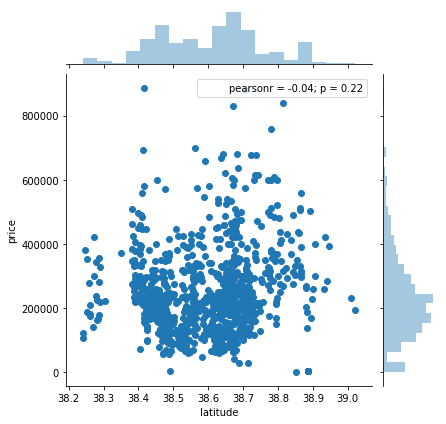

In [18]:
# It doesn't seem very correlated
sns.jointplot(df['latitude'], df['price'])

C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


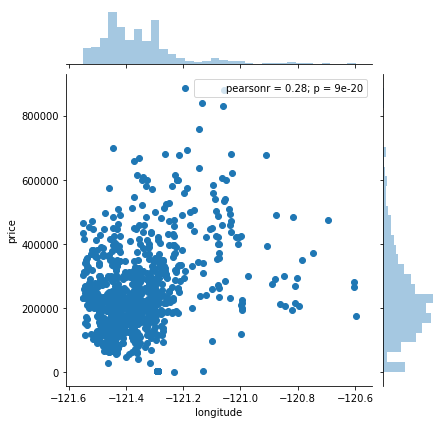

In [19]:
# It doesn't seem very correlated
sns.jointplot(df['longitude'], df['price'])

In [20]:
# Only one country :\
df['state'].value_counts()

CA    984
Name: state, dtype: int64

In [21]:
# Too many zip codes
df['zip'].value_counts().head(10)

95648    72
95823    61
95828    45
95758    44
95838    37
95835    36
95757    36
95624    34
95843    33
95621    28
Name: zip, dtype: int64

In [22]:
# this seems good!
df['city'].value_counts()

SACRAMENTO         438
ELK GROVE          114
LINCOLN             72
ROSEVILLE           48
CITRUS HEIGHTS      35
ANTELOPE            33
RANCHO CORDOVA      28
EL DORADO HILLS     23
GALT                21
NORTH HIGHLANDS     21
CARMICHAEL          20
FOLSOM              17
ROCKLIN             17
RIO LINDA           13
ORANGEVALE          11
PLACERVILLE         10
CAMERON PARK         9
FAIR OAKS            9
WILTON               5
AUBURN               5
ELVERTA              4
GOLD RIVER           4
POLLOCK PINES        3
RANCHO MURIETA       3
GRANITE BAY          3
WEST SACRAMENTO      3
LOOMIS               2
EL DORADO            2
MEADOW VISTA         1
COOL                 1
DIAMOND SPRINGS      1
FORESTHILL           1
GREENWOOD            1
GARDEN VALLEY        1
WALNUT GROVE         1
SHINGLE SPRINGS      1
SLOUGHHOUSE          1
PENRYN               1
MATHER               1
Name: city, dtype: int64

In [23]:
top_cities = df['city'].value_counts().head(10).index.values
top_cities

array(['SACRAMENTO', 'ELK GROVE', 'LINCOLN', 'ROSEVILLE',
       'CITRUS HEIGHTS', 'ANTELOPE', 'RANCHO CORDOVA', 'EL DORADO HILLS',
       'GALT', 'NORTH HIGHLANDS'], dtype=object)

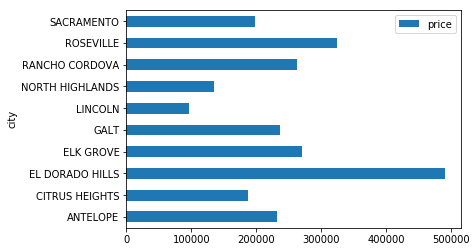

In [24]:
# MEAN
df[df['city'].isin(top_cities)].groupby('city').mean()[['price']].plot(kind='barh')

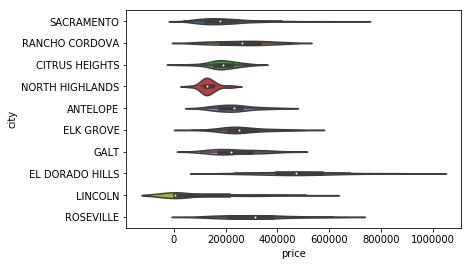

In [25]:
sns.violinplot(data=df[df['city'].isin(top_cities)], y='city', x='price')

In [26]:
df = pd.concat([df, 
           pd.get_dummies(df['city'])[top_cities].rename(columns=lambda c: 'city_'+c)], 
          axis=1)

In [27]:
df.columns

Index(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft',
       'sale_date', 'price', 'latitude', 'longitude', 'type__Condo',
       'type__Multi-Family', 'type__Residential', 'city_SACRAMENTO',
       'city_ELK GROVE', 'city_LINCOLN', 'city_ROSEVILLE',
       'city_CITRUS HEIGHTS', 'city_ANTELOPE', 'city_RANCHO CORDOVA',
       'city_EL DORADO HILLS', 'city_GALT', 'city_NORTH HIGHLANDS'],
      dtype='object')

In [28]:
features = features + [c for c in df.columns if 'city_' in c]
features

['beds',
 'baths',
 'sq__ft',
 'type__Condo',
 'type__Multi-Family',
 'type__Residential',
 'city_SACRAMENTO',
 'city_ELK GROVE',
 'city_LINCOLN',
 'city_ROSEVILLE',
 'city_CITRUS HEIGHTS',
 'city_ANTELOPE',
 'city_RANCHO CORDOVA',
 'city_EL DORADO HILLS',
 'city_GALT',
 'city_NORTH HIGHLANDS']

In [29]:
X = df[features]
y = df['price']

In [30]:
model = sm.OLS(y, X).fit() 

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     348.0
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        00:37:46   Log-Likelihood:                -12770.
No. Observations:                 984   AIC:                         2.557e+04
Df Residuals:                     968   BIC:                         2.565e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
beds                 -1.168e+04   5276.613     -2.213      0.027    -2.2e+04   -1320.594
baths                 3.855e+04   7419.562      5.196      0.000     2.4e+04    5.31e+04
sq__ft                  41.0785      6.207      6.618      0.000      28.897      53.260
type__Condo            1.72e+05   1.75e+04      9.802      0.000    1.38e+05    2.06e+05
type__Multi-Family    1.848e+05   3.37e+04      5.481      0.000    1.19e+05    2.51e+05
type__Residential     2.374e+05   1.26e+04     18.875      0.000    2.13e+05    2.62e+05
city_SACRAMENTO      -1.245e+05   1.01e+04    -12.353      0.000   -1.44e+05   -1.05e+05
city_ELK GROVE       -8.275e+04   1.33e+04     -6.230      0.000   -1.09e+05   -5.67e+04
city_LINCOLN         -1.591e+05   1.65e+04     -9.645      0.000   -1.92e+05   -1.27e+05
city_ROSEVILLE        1.846e+04   1.77e+04      1.046      0.296   -1.62e+04    5.31e+04
city_CITRUS HEIGHTS  -1.349e+05   1.99e+04     -6.783      0.000   -1.74e+05   -9.59e+04
city_ANTELOPE        -1.195e+05   2.04e+04     -5.870      0.000   -1.59e+05   -7.95e+04
city_RANCHO CORDOVA    -6.1e+04   2.18e+04     -2.801      0.005   -1.04e+05   -1.83e+04
city_EL DORADO HILLS  1.959e+05   2.53e+04      7.741      0.000    1.46e+05    2.46e+05
city_GALT            -1.028e+05   2.46e+04     -4.173      0.000   -1.51e+05   -5.45e+04
city_NORTH HIGHLANDS  -1.74e+05   2.48e+04     -7.028      0.000   -2.23e+05   -1.25e+05
==============================================================================
Omnibus:                      195.292   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              527.031
Skew:                           1.018   Prob(JB):                    3.60e-115
Kurtosis:                       5.951   Cond. No.                     1.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5) Plot the residuals ( y-true vs. y-pred) to evaluate your MLR visually.

> **Tip:** With Seaborn's `sns.lmplot`, you can set `x`, `y`, and even a `hue` (which will plot regression lines by category in different colors) to easily plot a regression line.

C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\dsiow\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


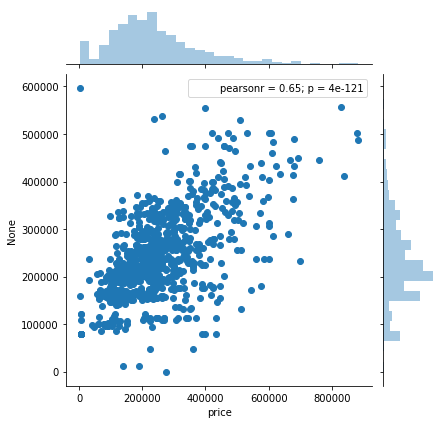

In [32]:
# A:

sns.jointplot(y, model.predict(X))

### 6) List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

In [33]:
# A:


### 7) Pick at least two assumptions and articulate whether or not you believe they were met for your model and why.

In [34]:
# A:

### 8) Explain what the intercept in your model means in the context of your predictor variables.

In [35]:
# A:

### 9) Generate a table showing the point estimates, standard errors, t-scores, p values, and 95 percent confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** Scikit-learn does not have this functionality built in, but  you can find it in the `summary` function in statsmodels.

In [36]:
# A:

### 10) [Bonus] Summarize your findings.

Picture this: You work for a real estate agency. You're asked to prepare an executive summary for your very busy boss highlighting the most important findings from your MLR model. Convey these findings in no more than two paragraphs. Be sure to briefly address any potential shortcomings of your model.


In [37]:
# A: 